# Setup

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

# Read Data as Numpy Array

In [2]:
# load train and test data
training_data = np.load("Data/training_data.npy", allow_pickle=True)
validation_data = np.load("Data/validation_data.npy", allow_pickle=True)
print("training data shape: {}".format(training_data.shape))
print("validation data shape: {}".format(validation_data.shape))

training data shape: (170, 2)
validation data shape: (158, 2)


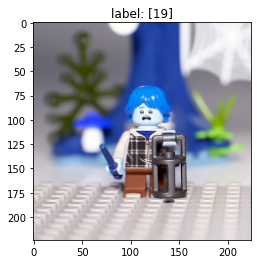

In [3]:
# plot example image
plt.imshow(training_data[0][0])
plt.title("label: {}".format(training_data[0][1]));

In [36]:
X_train = np.array([i[0] for i in training_data])
y_train = np.array([i[1] for i in training_data])
X_valid = np.array([i[0] for i in validation_data])
y_valid = np.array([i[1] for i in validation_data])

In [37]:
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

In [6]:
#BATCH_SIZE = 10
#SHUFFLE_BUFFER_SIZE = len(X_train)

#train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
#valid_dataset = valid_dataset.batch(BATCH_SIZE)

# Prepare Data for Training

In [68]:
# augment and normalize data

# create data generator
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=5)
valid_datagen = ImageDataGenerator(rescale=1./255)

# create an iterator for the datasets.
# the iterator will return one batch of augmented images for each iteration
epochs = 20
batch_size = 10
IMG_SIZE = 224
total_train = X_train.shape[0]
total_valid = X_valid.shape[0]

iter_train = train_datagen.flow(X_train, y_train, batch_size=batch_size,
                                shuffle=True)
iter_valid = train_datagen.flow(X_valid, y_valid, batch_size=batch_size)

# Visualize some Images

In [60]:
sample_training_images, sample_training_labels = next(iter_train)

In [61]:
print("Shape of a sample batch of images: {}".format(sample_training_images.shape))
print("Shape of a sample lables: {}".format(sample_training_labels.shape))

Shape of a sample batch of images: (10, 224, 224, 3)
Shape of a sample lables: (10, 1)


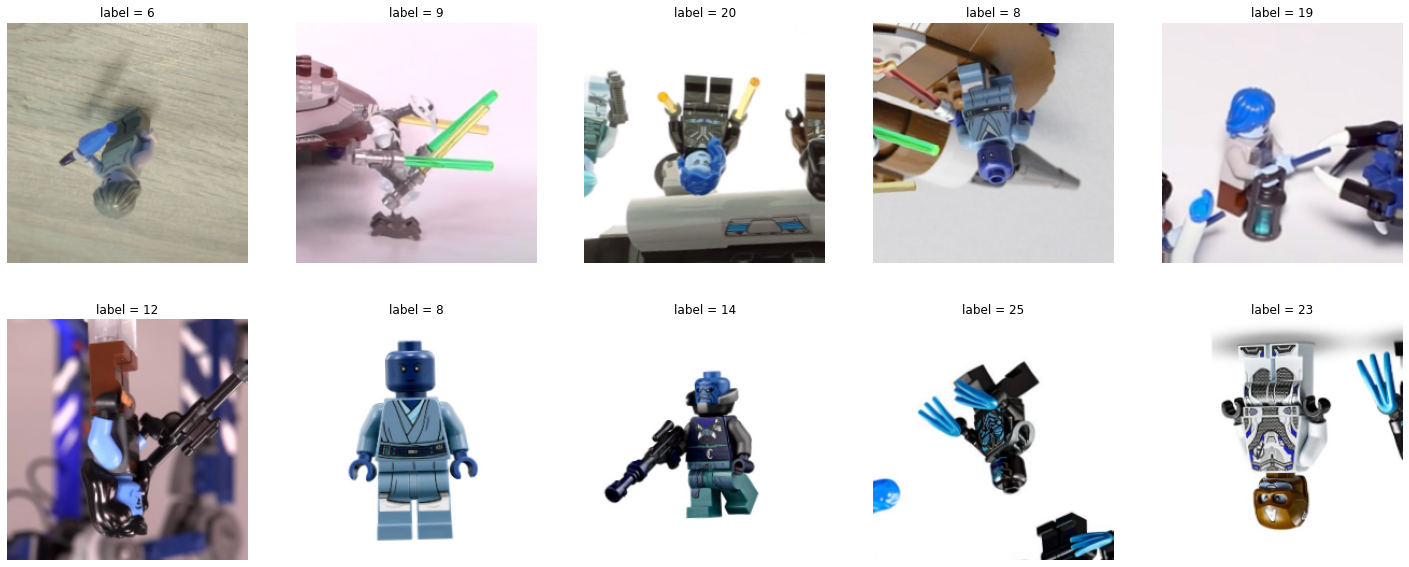

In [89]:
fig, axes = plt.subplots(2, 5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_training_images[i])
    ax.axis('off')
    ax.set_title("label = " + str(sample_training_labels[i].item()))

# Build the Model

In [63]:
# define the model
model =Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE ,3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(256, (5, 5), activation='relu'),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(30, activation='softmax')
])

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 220, 220, 32)      2432      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 106, 106, 64)      51264     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 49, 49, 128)       204928    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 256)      

# Train the Model

In [65]:
# compile the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [74]:
# train the model
history = model.fit(
    iter_train,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=iter_valid,
    validation_steps=total_valid // batch_size,
    callbacks=[callback]
)

Epoch 1/20
17/17 [==============================] - 16s 964ms/step - loss: 3.4157 - accuracy: 0.0000e+00 - val_loss: 3.4096 - val_accuracy: 0.0000e+00
Epoch 2/20
17/17 [==============================] - 18s 1s/step - loss: 3.4098 - accuracy: 0.0000e+00 - val_loss: 3.4366 - val_accuracy: 0.0000e+00
Epoch 3/20
17/17 [==============================] - 18s 1s/step - loss: 3.4098 - accuracy: 0.0000e+00 - val_loss: 3.4231 - val_accuracy: 0.0000e+00
Epoch 4/20
17/17 [==============================] - 19s 1s/step - loss: 3.4216 - accuracy: 0.0000e+00 - val_loss: 3.4028 - val_accuracy: 0.0000e+00
Epoch 5/20
17/17 [==============================] - 18s 1s/step - loss: 3.4040 - accuracy: 0.0000e+00 - val_loss: 3.4164 - val_accuracy: 0.0000e+00
Epoch 6/20
17/17 [==============================] - 18s 1s/step - loss: 3.4334 - accuracy: 0.0000e+00 - val_loss: 3.4096 - val_accuracy: 0.0000e+00
Epoch 7/20
17/17 [==============================] - 18s 1s/step - loss: 3.4157 - accuracy: 0.0000e+00 - val_l

# Plot Results

In [87]:
def plot_acc_loss(acc, val_acc, loss, val_loss):

    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, color="#58D68D", linewidth=2, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, color="#F1C40F", linewidth=2, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.ylim(0,1)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, color="#58D68D", linewidth=2, label='Training Loss')
    plt.plot(epochs_range, val_loss, color="#F1C40F", linewidth=2, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

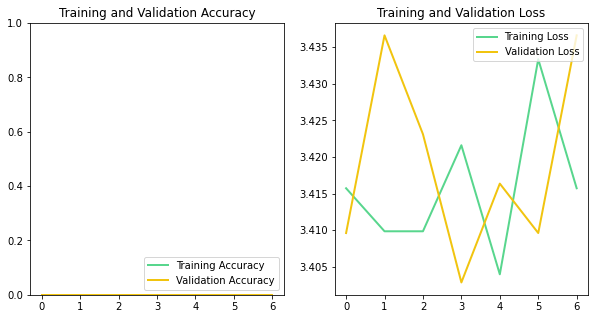

In [88]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plot_acc_loss(acc, val_acc, loss, val_loss)

# Plot some example Predictions

In [93]:
sample_test_images, sample_test_labels = next(iter_valid)
predictions = model.predict(sample_test_images)

In [97]:
print("SOME PREDICTIONS:")
for i in range(5,10):
    print("-"*20)
    print("Predicted cell type of the first image: {}.".format(np.argmax(predictions[i])))
    print("True label: {}".format(int(sample_test_labels[i])))

SOME PREDICTIONS:
--------------------
Predicted cell type of the first image: 8.
True label: 26
--------------------
Predicted cell type of the first image: 8.
True label: 14
--------------------
Predicted cell type of the first image: 8.
True label: 20
--------------------
Predicted cell type of the first image: 8.
True label: 18
--------------------
Predicted cell type of the first image: 8.
True label: 27


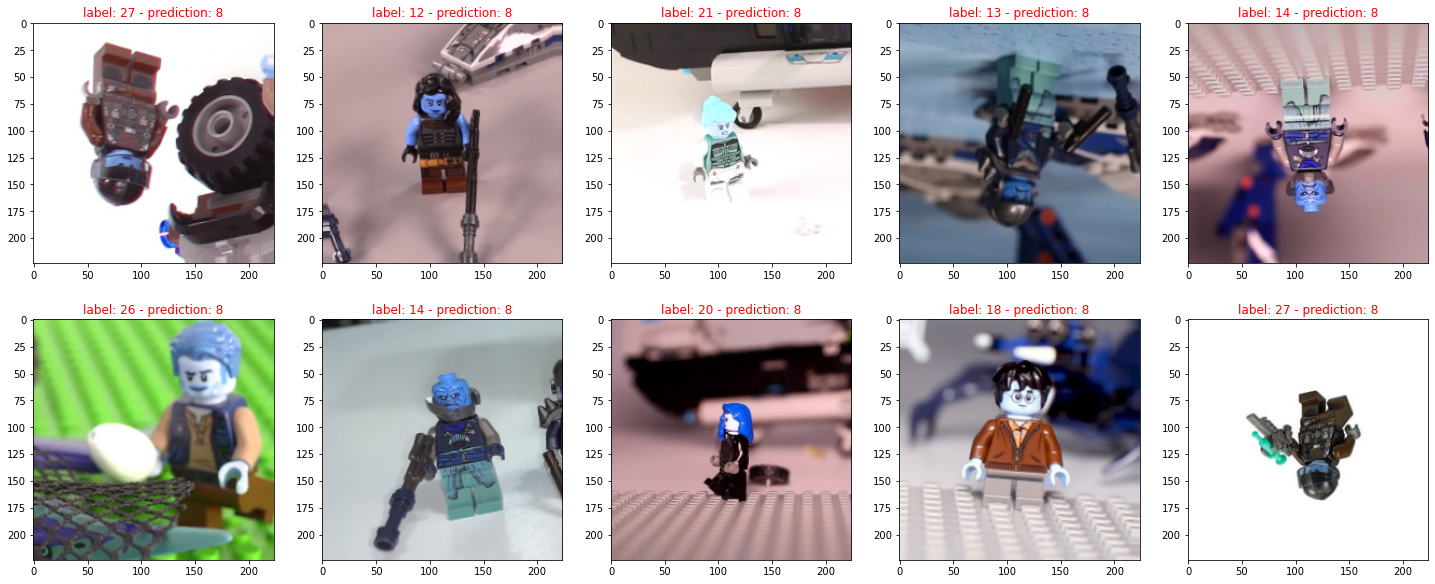

In [105]:
fig, axes = plt.subplots(2,5, figsize=(25,10))

for i, ax in enumerate(axes.flatten()):
    
    ax.imshow(sample_test_images[i])
    ax.set_title(f'label: {sample_test_labels[i].item()} - prediction: {np.argmax(predictions[i])}', 
                color=("green" if np.argmax(predictions[i])==sample_test_labels[i].item() else "red"))

# ToDo

* Hyperparameter Tuning
* Test Pretrained Model